In [1]:
%reload_ext autoreload
%autoreload 2

import time as tt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from utils import get_track

## First, start by defining the paramters

In [2]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in km/s

# Integration time
time = 4. # Gyr
alpha = 1.0

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

n_steps = 500 # Number of steps in the time integration
n_particles = 10000 # Number of particles in the stream

In [3]:
from gala_spray import model_stream
xv_stream_gala = model_stream(params[:-1], dt=-time/100)

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

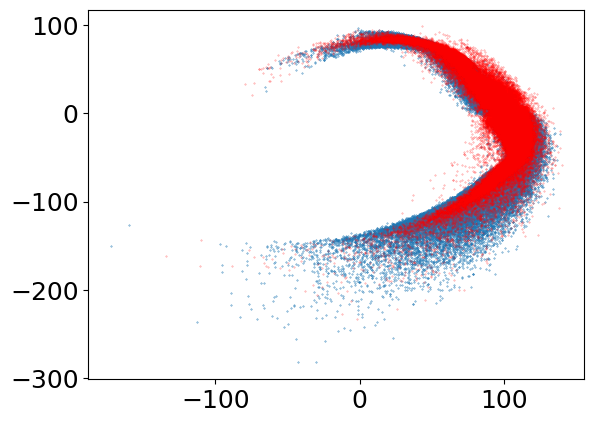

In [ ]:
plt.scatter(xv_stream_gala[:,0], xv_stream_gala[:,1], s=0.1)
plt.scatter(xv_stream_spray[:, 0], xv_stream_spray[:, 1], s=0.1, color='r', alpha=0.5)


## (1) Spray Method

In [4]:
from spray import generate_stream_spray

start = tt.time()
theta_stream, xv_stream_spray = generate_stream_spray(params,  111)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream_spray[:, 0], xv_stream_spray[:, 1])

Time taken to generate stream using Spray: 1.51 seconds


In [7]:
np.where(theta_stream > 3*np.pi/2)

(array([400, 401, 403, 407, 422, 427, 429, 437, 440, 444, 446, 449, 450,
        455, 464, 466, 470, 472, 483, 489, 499]),)

In [9]:
theta_stream[400]

Array(5.72372456, dtype=float64)

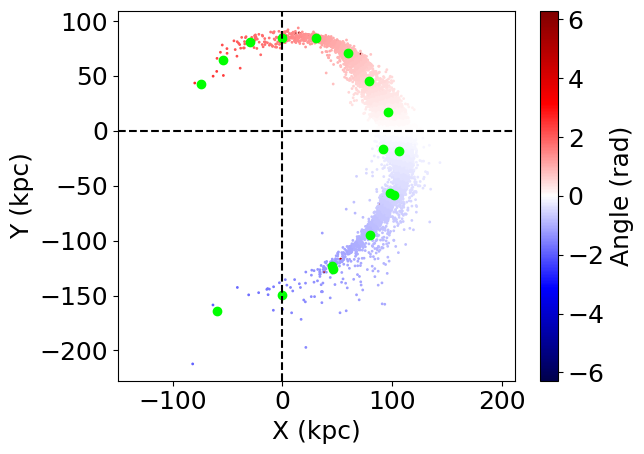

In [5]:
plt.scatter(xv_stream_spray[:, 0], xv_stream_spray[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [ ]:
from models import generate_stream_streak

start = tt.time()
theta_stream, xv_stream = generate_stream_streak(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Spray: 0.17 seconds


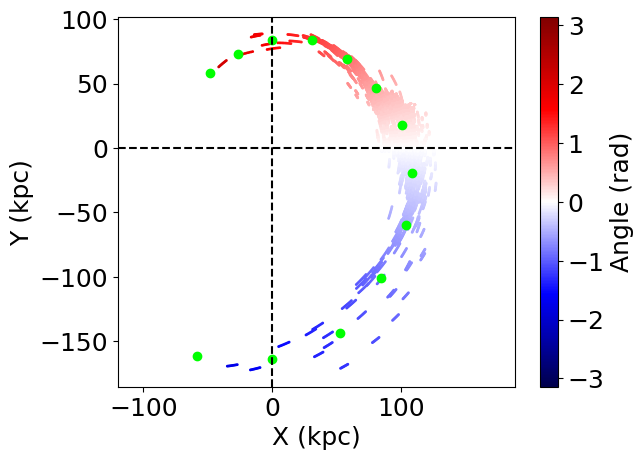

In [44]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (3) Binned method

In [36]:
from models import generate_stream_bin

start = tt.time()
theta_stream, xv_stream, count_stream = generate_stream_bin(params,  seed=111, n_bins=1000, n_steps=n_steps, n_particles=n_particles)

end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Streak: 0.94 seconds


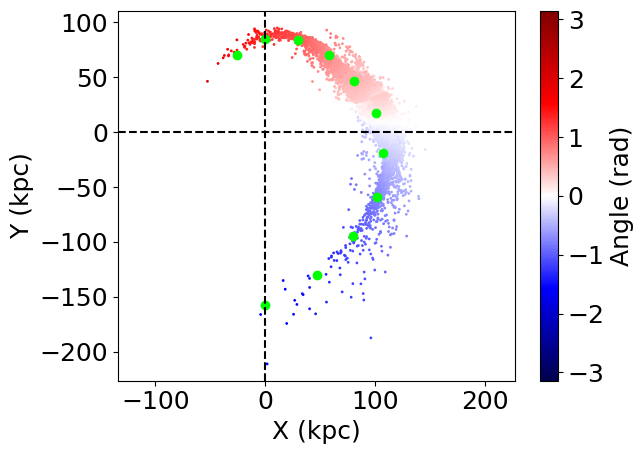

In [39]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=count_stream, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (4) 2nd Degree method

In [5]:
%reload_ext autoreload
%autoreload 2

from models import generate_stream_first

n_particles = 1000

start = tt.time()
theta_stream, xv_stream_first, S, dS = generate_stream_first(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using First: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream_first[:, 0], xv_stream_first[:, 1])

/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Time taken to generate stream using First: 1.73 seconds


In [24]:
from integrants import integrate_satellite, NFWHessian
from utils import get_rj_vj_R, create_ic_particle_spray, jax_unwrap
import jax.numpy as jnp
import jax

tail=0
seed=111
n_particles=10000

logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = params
backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time, n_steps)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha, n_steps)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)
ic_particle_spray = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed, n_particles, n_steps)

n_particles=1000
logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = params
backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time, n_steps)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha, n_steps)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)
ic_particle_spray_base = create_ic_particle_spray(forward_trajectory, rj, vj, R, tail, seed, n_particles, n_steps)

In [25]:
hessians

Array([[[ 0.78597992, -2.44386705,  0.26578987],
        [-2.44386705, -2.22773613,  0.70309637],
        [ 0.26578987,  0.70309637,  2.23696674]],

       [[ 0.8269175 , -2.42883433,  0.27342398],
        [-2.42883433, -2.2642888 ,  0.73274577],
        [ 0.27342398,  0.73274577,  2.23344447]],

       [[ 0.86821425, -2.41316012,  0.28064902],
        [-2.41316012, -2.30073448,  0.76260654],
        [ 0.28064902,  0.76260654,  2.22992218]],

       ...,

       [[-3.40582657, -2.24798942,  0.73667325],
        [-2.24798942,  1.9458914 ,  0.02675903],
        [ 0.73667325,  0.02675903,  2.86679355]],

       [[-3.35403901, -2.29920399,  0.73365497],
        [-2.29920399,  1.87942702,  0.04112717],
        [ 0.73365497,  0.04112717,  2.85367299]],

       [[-3.30148645, -2.3486869 ,  0.73020353],
        [-2.3486869 ,  1.81273236,  0.05517916],
        [ 0.73020353,  0.05517916,  2.84088445]]], dtype=float64)

In [7]:
even = ic_particle_spray[::2]
even_base = ic_particle_spray_base[::2]
even_approxed = jnp.einsum('nij,nkj->nki', S[::2], even[:, :6].reshape((n_steps, -1, 6)) - even_base[:, None, :6])
even_new = (xv_stream_first[::2, None, :3] + even_approxed).reshape(-1, 3)

odd = ic_particle_spray[1::2]
odd_base = ic_particle_spray_base[1::2]
odd_approxed = jnp.einsum('nij,nkj->nki', S[1::2], odd[:, :6].reshape((n_steps, -1, 6)) - odd_base[:, None, :6])
odd_new = (xv_stream_first[1::2, None, :3] + odd_approxed).reshape(-1, 3)


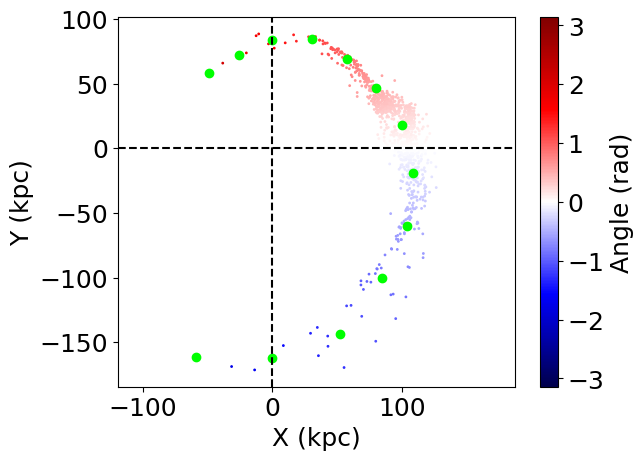

In [8]:
plt.scatter(xv_stream_first[:, 0], xv_stream_first[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

(-200.0, 200.0)

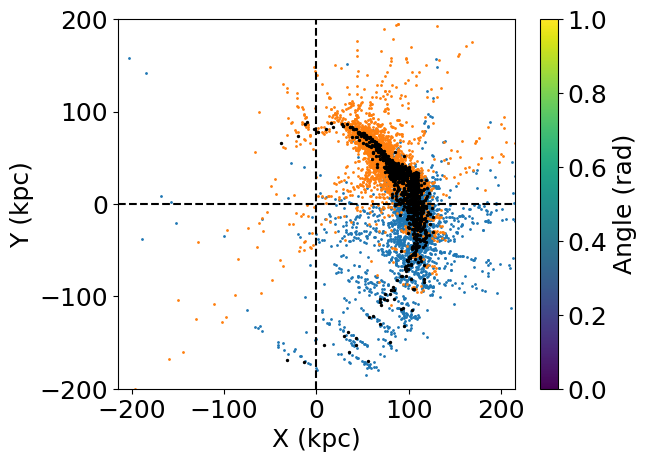

In [21]:
plt.scatter(even_new[:, 0], even_new[:, 1], s=1)#, c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.scatter(odd_new[:, 0], odd_new[:, 1], s=1)#, c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.scatter(xv_stream_first[:, 0], xv_stream_first[:, 1], c='k', s=2)
plt.colorbar(label='Angle (rad)')
# plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');
plt.xlim(-200, 200)
plt.ylim(-200, 200)

In [100]:
from constants import *

KPC_TO_KM, GYR_TO_S

(3.085677581491367e+16, 3.15576e+16)

In [104]:
hessians * KPC_TO_KM**-2 * GYR_TO_S

Array([[[ 2.60503959e-17, -8.09991485e-17,  8.80929798e-18],
        [-8.09991485e-17, -7.38357388e-17,  2.33033165e-17],
        [ 8.80929798e-18,  2.33033165e-17,  7.41416766e-17]],

       [[ 2.74072248e-17, -8.05009064e-17,  9.06232159e-18],
        [-8.05009064e-17, -7.50472347e-17,  2.42860117e-17],
        [ 9.06232159e-18,  2.42860117e-17,  7.40249350e-17]],

       [[ 2.87759578e-17, -7.99814026e-17,  9.30178723e-18],
        [-7.99814026e-17, -7.62551848e-17,  2.52757122e-17],
        [ 9.30178723e-18,  2.52757122e-17,  7.39081928e-17]],

       ...,

       [[-1.12882185e-16, -7.45070109e-17,  2.44161832e-17],
        [-7.45070109e-17,  6.44943210e-17,  8.86897192e-19],
        [ 2.44161832e-17,  8.86897192e-19,  9.50165584e-17]],

       [[-1.11165746e-16, -7.62044583e-17,  2.43161457e-17],
        [-7.62044583e-17,  6.22914359e-17,  1.36311262e-18],
        [ 2.43161457e-17,  1.36311262e-18,  9.45816926e-17]],

       [[-1.09423952e-16, -7.78445122e-17,  2.42017518e-17],
 

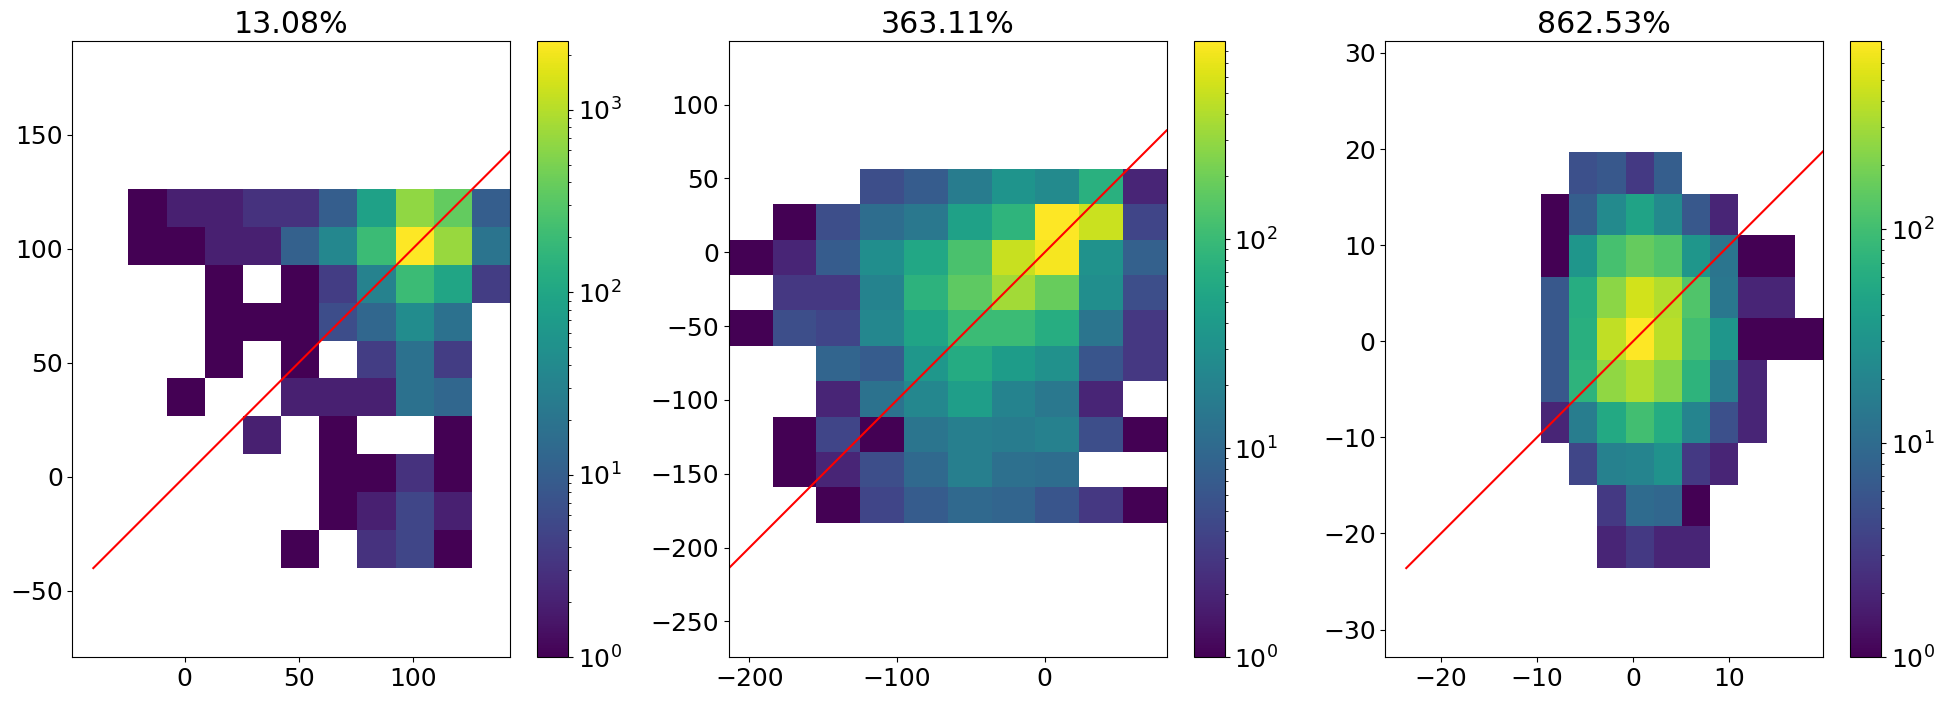

In [93]:
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.title(f'{100*np.mean(abs(xv_stream_spray[::2,0]-even_new[:, 0])/abs(xv_stream_spray[::2,0])):.2f}%')
plt.hist2d(xv_stream_spray[::2,0], even_new[:, 0], norm='log')
min = np.min([xv_stream_spray[::2,0], even_new[:, 0]])
max = np.max([xv_stream_spray[::2,0], even_new[:, 0]])
plt.plot([min, max], [min, max],c='r')
plt.axis('equal')
plt.colorbar()
plt.subplot(1,3,2)
plt.title(f'{100*np.mean(abs(xv_stream_spray[::2,1]-even_new[:, 1])/abs(xv_stream_spray[::2,1])):.2f}%')
plt.hist2d(xv_stream_spray[::2,1], even_new[:, 1], norm='log')
min = np.min([xv_stream_spray[::2,1], even_new[:, 1]])
max = np.max([xv_stream_spray[::2,1], even_new[:, 1]])
plt.plot([min, max], [min, max],c='r')
plt.axis('equal')
plt.colorbar()
plt.subplot(1,3,3)
plt.title(f'{100*np.mean(abs(xv_stream_spray[::2,2]-even_new[:, 2])/abs(xv_stream_spray[::2,2])):.2f}%')
plt.hist2d(xv_stream_spray[::2,2], even_new[:, 2], norm='log')
min = np.min([xv_stream_spray[::2,2], even_new[:, 2]])
max = np.max([xv_stream_spray[::2,2], even_new[:, 2]])
plt.plot([min, max], [min, max],c='r')
plt.axis('equal')
plt.colorbar()